In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#William Connor Parham
#Dr. Hairong Qi
#COSC 522
#Project 1
#9/19/2023

**Read In Training and Testing Set**


Text(0.5, 1.0, 'Positive and Negative Synthetic training Data')

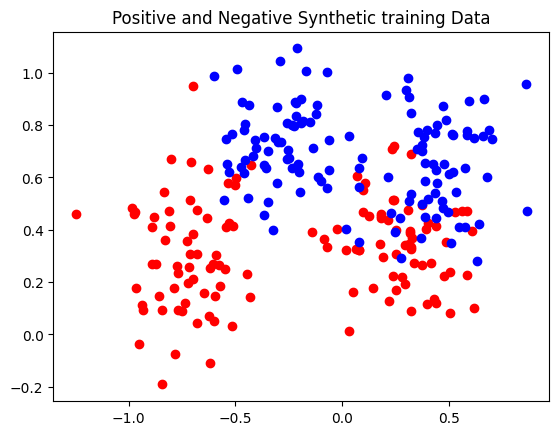

In [3]:
#Read in our training and testing files
training_set = np.loadtxt("synth.tr",skiprows=1)
testing_set = np.loadtxt("synth.te", skiprows=1)

#Instantiate arrays to graph our training data
training_set_x_c1, training_set_y_c1 = [], []
training_set_x_c2, training_set_y_c2 = [], []
testing_set_x_c1, testing_set_y_c1 = [], []
testing_set_x_c2, testing_set_y_c2 = [], []

#sort our training data by class.
for item in training_set:
    if(item[2] == 0):
        training_set_x_c1.append(item[0])
        training_set_y_c1.append(item[1])
    else:
        training_set_x_c2.append(item[0])
        training_set_y_c2.append(item[1])

#Plot our data
plt.scatter(training_set_x_c1, training_set_y_c1,c='red')
plt.scatter(training_set_x_c2, training_set_y_c2, c='blue')
plt.title('Positive and Negative Synthetic training Data')

**Minimum Euclidean Distance Classifier**

Total Accuracy:  82.6
Class 0 Accuracy:  73.0
Class 1 Accuracy:  92.2
len xx:  15
len yy:  15
len r1:  360
len r2:  360
len r1 after reshape:  360
len r2 after reshape:  360
grid len: 
 360
preds len:  360


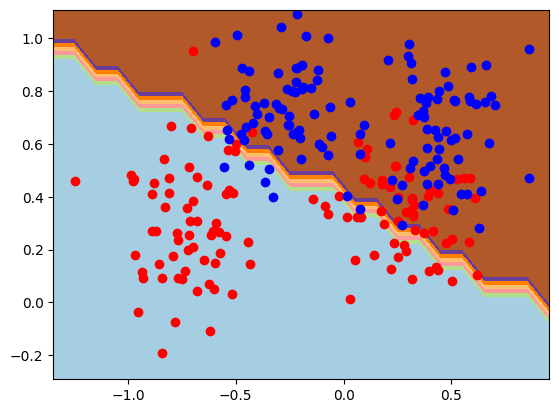

In [39]:
class MED_Classifier():
    
    def _innit_(self):
        self.X_train = [] #x_train data
        self.y_train = [] #y_train data
        self.classes = [] #list of classes
        self.means = [] #list to hold class means used in predict.
        self.sigmas = None #list to hold each sigma value

    #We will fit our training_set to the classifier here.  This is what "trains" our model to be able to predict things.
    def fit(self,training_set):
        #The first thing we need to do is sepperate our training set into lists based on class.
        #We can do this by concatting every class in our training set then calling np.unique to get all unique values.
        self.classes = np.unique(training_set[:,2])
        class_means = [] #list to hold all class means
        self.class_0_data, self.class_1_data = [], [] #list to hold all points of class 0 and 1 data
        class_0_data_nc, class_1_data_nc = [], [] #list to hold all points of class 0 and 1 data without the class variable
        class_0_centered, class_1_centered = [], [] #list to hold centered data after subtracting mean
        c0_cov = [] #list to hold the covariance matrix for class 0
        c1_cov = [] #list to hold the covariance matrix for class 1
        sigmas = [] #list to gold the sigma values for each class

        for item in training_set:
            if(item[2] == 0):
                self.class_0_data.append(item)
            else:
                self.class_1_data.append(item)

        #Here I am stripping the class column off each array
        temp = []
        for subarray in self.class_0_data:
            temp.append(subarray[:2])
        class_0_data_nc = temp
        temp = []
        for subarray in self.class_1_data:
            temp.append(subarray[:2])
        class_1_data_nc = temp

        #Calculate the mean of each class's data cluster
        class_means.append(np.mean(class_0_data_nc, axis=0))
        class_means.append(np.mean(class_1_data_nc, axis=0))
        
        self.means = class_means

        #center our data by subtracting the mean from each point
        class_0_centered = class_0_data_nc - class_means[0]
        class_1_centered = class_1_data_nc - class_means[1]

        #calculate the covariance of each class
        c0_cov = np.cov(class_0_centered,rowvar=False)
        c1_cov = np.cov(class_1_centered, rowvar=False)

        ##I have no idea if this is correct.  This is worth checking with a ta or Dr. Qi.
        #Find the variance / sigma of both class 1 and class 2
        variance = 0
        for i in range(0, 2):
            variance += c0_cov[i][i]
        sigmas.append(variance/2)

        variance = 0
        for i in range(0, 2):
            variance += c1_cov[i][i]
        sigmas.append(variance/2)
        self.sigmas = sigmas

    #We will make predictions about our testing_set here.  This is what will "classify the data for us".
    def predict(self,testing_set):
        #for each testing point we want to find the minimum euclidean distance to the mean of the data.
        self.actual_class = [] #variable to hold the actual class of the testing set
        self.probs = [] #variable to hold probabilities for each class, probs[0] = class 0 & probs[1] = class 1
        self.testing_set_class_0 = testing_set[testing_set[:, -1] == 0][:, :3]  # Data points in class 0
        self.testing_set_class_1 = testing_set[testing_set[:, -1] == 1][:, :3]  # Data points in class 1
        self.prior = 0.5 #prior knowledge constant

        for i in range(0, len(testing_set)):
            self.actual_class.append(testing_set[i][2])
            c0 = (np.dot(np.transpose(self.means[0]) / self.sigmas[0], testing_set[i, :2]) - np.dot(np.transpose(self.means[0]), self.means[0]) / (2 * self.sigmas[0]) + np.log(self.prior))
            c1 = (np.dot(np.transpose(self.means[1]) / self.sigmas[1], testing_set[i, :2]) - np.dot(np.transpose(self.means[1]), self.means[1]) / (2 * self.sigmas[1]) + np.log(self.prior))

            self.probs.append((c0,c1))

    #We will evaluate our model here    
    def evaluate(self):
        #loop through each probability and determine whether class 0 or class 1 is higher.
        #compare the chosen probability to the actual probability inside self.actual_class.
        #if correct add +1 to accuracy counter.
        #divide correct scores by total scores to find percent classified correctly.

        chosen_class = None
        accuracy_counter = 0
        class_0_counter = 0
        class_1_counter = 0
        for i in range(0, len(self.probs)):
            if(self.probs[i][0] > self.probs[i][1]):
                chosen_class = 0
            else:
                chosen_class = 1
                
            if(chosen_class == self.actual_class[i]):
                accuracy_counter += 1
                if(chosen_class == 0):
                    class_0_counter += 1
                else:
                    class_1_counter += 1
        
        print('Total Accuracy: ', 100 * (accuracy_counter / (len(self.probs))))
        print('Class 0 Accuracy: ', 100 * (class_0_counter / 500))
        print('Class 1 Accuracy: ', 100 * (class_1_counter / 500))

    def make_preds(self, grid):

        self.pred_list = []
        self.pred_probs = []
        for i in range(0, len(grid)):
            c0 = (np.dot(np.transpose(self.means[0]) / self.sigmas[0], grid[i, :2]) - np.dot(np.transpose(self.means[0]), self.means[0]) / (2 * self.sigmas[0]) + np.log(self.prior))
            c1 = (np.dot(np.transpose(self.means[1]) / self.sigmas[1], grid[i, :2]) - np.dot(np.transpose(self.means[1]), self.means[1]) / (2 * self.sigmas[1]) + np.log(self.prior))

            self.pred_probs.append((c0,c1))

        for i in range(0, len(self.pred_probs)):
            if(self.pred_probs[i][0] > self.pred_probs[i][1]):
                self.pred_list.append(0)
            else:
                self.pred_list.append(1)
        
        return self.pred_list
    
    def vis(self):
        #define bounds of the doman
        min1, max1 = training_set[:, 0].min() - .1, training_set[:, 0].max() + .1
        min2, max2 = training_set[:, 1].min() - .1, training_set[:, 1].max() + .1
        x1grid = np.arange(min1, max1, 0.1)
        x2grid = np.arange(min2, max2, 0.1)
        xx, yy = np.meshgrid(x1grid, x2grid)
        r1, r2 = xx.flatten(), yy.flatten()
        r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
        grid = np.hstack((r1, r2))
        preds = self.make_preds(grid)
        preds = np.array(preds)
        zz = preds.reshape(xx.shape)

        plt.contourf(xx, yy, zz, cmap='Paired')
        plt.scatter(training_set_x_c1, training_set_y_c1,c='red')
        plt.scatter(training_set_x_c2, training_set_y_c2, c='blue')
        

med_classifier = MED_Classifier()
med_classifier.fit(training_set=training_set)
med_classifier.predict(testing_set=testing_set)
med_classifier.evaluate()
med_classifier.vis()

**Minimum Mahalanobis Distance Classifier**

In [5]:
class MMD_Classifier():
    
    def _innit_(self):
        self.X_train = [] #x_train data
        self.y_train = [] #y_train data
        self.classes = [] #list of classes
        self.means = [] #list to hold class means used in predict.
        self.sigmas = None #list to hold each sigma value

    #We will fit our training_set to the classifier here.  This is what "trains" our model to be able to predict things.
    def fit(self,training_set):
        #The first thing we need to do is sepperate our training set into lists based on class.
        #We can do this by concatting every class in our training set then calling np.unique to get all unique values.
        self.classes = np.unique(training_set[:,2])
        class_means = [] #list to hold all class means
        class_0_data, class_1_data = [], [] #list to hold all points of class 0 and 1 data
        class_0_data_nc, class_1_data_nc = [], [] #list to hold all points of class 0 and 1 data without the class variable
        class_0_centered, class_1_centered = [], [] #list to hold centered data after subtracting mean
        c0_cov = [] #list to hold the covariance matrix for class 0
        c1_cov = [] #list to hold the covariance matrix for class 1
        sigmas = [] #list to gold the sigma values for each class

        for item in training_set:
            if(item[2] == 0):
                class_0_data.append(item)
            else:
                class_1_data.append(item)

        #Here I am stripping the class column off each array
        temp = []
        for subarray in class_0_data:
            temp.append(subarray[:2])
        class_0_data_nc = temp
        temp = []
        for subarray in class_1_data:
            temp.append(subarray[:2])
        class_1_data_nc = temp

        #Calculate the mean of each class's data cluster
        class_means.append(np.mean(class_0_data_nc, axis=0))
        class_means.append(np.mean(class_1_data_nc, axis=0))
        
        self.means = class_means

        #center our data by subtracting the mean from each point
        class_0_centered = class_0_data_nc - class_means[0]
        class_1_centered = class_1_data_nc - class_means[1]

        #calculate the covariance of each class
        self.c0_cov = np.cov(class_0_centered,rowvar=False)
        self.c1_cov = np.cov(class_1_centered, rowvar=False)

        ##I have no idea if this is correct.  This is worth checking with a ta or Dr. Qi.
        #Find the variance / sigma of both class 1 and class 2
        variance = 0
        for i in range(0, 2):
            variance += self.c0_cov[i][i]
        sigmas.append(variance/2)

        variance = 0
        for i in range(0, 2):
            variance += self.c1_cov[i][i]
        sigmas.append(variance/2)
        self.sigmas = sigmas

    #We will make predictions about our testing_set here.  This is what will "classify the data for us".
    def predict(self,testing_set):
        #for each testing point we want to find the minimum euclidean distance to the mean of the data.
        self.actual_class = [] #variable to hold the actual class of the testing set
        self.probs = [] #variable to hold probabilities for each class, probs[0] = class 0 & probs[1] = class 1
        self.testing_set_class_0 = testing_set[testing_set[:, -1] == 0][:, :3]  # Data points in class 0
        self.testing_set_class_1 = testing_set[testing_set[:, -1] == 1][:, :3]  # Data points in class 1
        self.prior = 0.5 #prior knowledge constant

        #print('blorbus: ', self.testing_set_class_0[0][:2])
        for i in range(0, len(testing_set)):
            self.actual_class.append(testing_set[i][2])
            
            c0 = np.linalg.multi_dot([np.transpose(self.means[0]), np.transpose(np.linalg.inv(self.c0_cov)), testing_set[i, :2]]) + (-0.5) * np.linalg.multi_dot([np.transpose(self.means[0]), np.linalg.inv(self.c0_cov), self.means[0]]) + np.log(self.prior)
            c1 = np.linalg.multi_dot([np.transpose(self.means[1]), np.transpose(np.linalg.inv(self.c1_cov)), testing_set[i][:2]]) + (-0.5) * np.linalg.multi_dot([np.transpose(self.means[1]), np.linalg.inv(self.c1_cov), self.means[1]]) + np.log(self.prior)

            self.probs.append((c0,c1))

    #We will evaluate our model here    
    def evaluate(self):
        #loop through each probability and determine whether class 0 or class 1 is higher.
        #compare the chosen probability to the actual probability inside self.actual_class.
        #if correct add +1 to accuracy counter.
        #divide correct scores by total scores to find percent classified correctly.

        chosen_class = None
        accuracy_counter = 0
        class_0_counter = 0
        class_1_counter = 0
        for i in range(0, len(self.probs)):
            if(self.probs[i][0] > self.probs[i][1]):
                chosen_class = 0
            else:
                chosen_class = 1
                
            if(chosen_class == self.actual_class[i]):
                accuracy_counter += 1
                if(chosen_class == 0):
                    class_0_counter += 1
                else:
                    class_1_counter += 1
                    
        print('Accuracy: ', 100 * (accuracy_counter / (len(self.probs))))
        print('Class 0 Accuracy: ', 100 * (class_0_counter / 500))
        print('Class 1 Accuracy: ', 100 * (class_1_counter / 500))

        
    def make_preds(self, grid):

        self.pred_list = []
        self.pred_probs = []
        for i in range(0, len(grid)):
            c0 = np.linalg.multi_dot([np.transpose(self.means[0]), np.transpose(np.linalg.inv(self.c0_cov)), testing_set[i, :2]]) + (-0.5) * np.linalg.multi_dot([np.transpose(self.means[0]), np.linalg.inv(self.c0_cov), self.means[0]]) + np.log(self.prior)
            c1 = np.linalg.multi_dot([np.transpose(self.means[1]), np.transpose(np.linalg.inv(self.c1_cov)), testing_set[i][:2]]) + (-0.5) * np.linalg.multi_dot([np.transpose(self.means[1]), np.linalg.inv(self.c1_cov), self.means[1]]) + np.log(self.prior)

            self.pred_probs.append((c0,c1))

        for i in range(0, len(self.pred_probs)):
            if(self.pred_probs[i][0] > self.pred_probs[i][1]):
                self.pred_list.append(0)
            else:
                self.pred_list.append(1)
        
        return self.pred_list
    
    def vis(self):
        #define bounds of the doman
        min1, max1 = training_set[:, 0].min() - .1, training_set[:, 0].max() + .1
        min2, max2 = training_set[:, 1].min() - .1, training_set[:, 1].max() + .1
        x1grid = np.arange(min1, max1, 0.1)
        x2grid = np.arange(min2, max2, 0.1)
        xx, yy = np.meshgrid(x1grid, x2grid)
        r1, r2 = xx.flatten(), yy.flatten()
        r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
        grid = np.hstack((r1, r2))
        preds = self.make_preds(grid)
        preds = np.array(preds)
        zz = preds.reshape(xx.shape)

        plt.contourf(xx, yy, zz, cmap='Paired')
        plt.scatter(training_set_x_c1, training_set_y_c1,c='red')
        plt.scatter(training_set_x_c2, training_set_y_c2, c='blue')

mmd_classifier = MMD_Classifier()
mmd_classifier.fit(training_set=training_set)
mmd_classifier.predict(testing_set=testing_set)
mmd_classifier.evaluate()

Accuracy:  87.1
Class 0 Accuracy:  84.0
Class 1 Accuracy:  90.2


**Maximum Posterior Probability Classifier**


In [6]:
class MPP_Classifier():
    
    def _innit_(self):
        self.X_train = [] #x_train data
        self.y_train = [] #y_train data
        self.classes = [] #list of classes
        self.means = [] #list to hold class means used in predict.
        self.sigmas = None #list to hold each sigma value

    #We will fit our training_set to the classifier here.  This is what "trains" our model to be able to predict things.
    def fit(self,training_set):
        #The first thing we need to do is sepperate our training set into lists based on class.
        #We can do this by concatting every class in our training set then calling np.unique to get all unique values.
        self.classes = np.unique(training_set[:,2])
        class_means = [] #list to hold all class means
        class_0_data, class_1_data = [], [] #list to hold all points of class 0 and 1 data
        class_0_data_nc, class_1_data_nc = [], [] #list to hold all points of class 0 and 1 data without the class variable
        class_0_centered, class_1_centered = [], [] #list to hold centered data after subtracting mean
        c0_cov = [] #list to hold the covariance matrix for class 0
        c1_cov = [] #list to hold the covariance matrix for class 1
        sigmas = [] #list to gold the sigma values for each class

        for item in training_set:
            if(item[2] == 0):
                class_0_data.append(item)
            else:
                class_1_data.append(item)

        #Here I am stripping the class column off each array
        temp = []
        for subarray in class_0_data:
            temp.append(subarray[:2])
        class_0_data_nc = temp
        temp = []
        for subarray in class_1_data:
            temp.append(subarray[:2])
        class_1_data_nc = temp

        #Calculate the mean of each class's data cluster
        class_means.append(np.mean(class_0_data_nc, axis=0))
        class_means.append(np.mean(class_1_data_nc, axis=0))
        
        self.means = class_means

        #center our data by subtracting the mean from each point
        class_0_centered = class_0_data_nc - class_means[0]
        class_1_centered = class_1_data_nc - class_means[1]

        #calculate the covariance of each class
        self.c0_cov = np.cov(class_0_centered,rowvar=False)
        self.c1_cov = np.cov(class_1_centered, rowvar=False)

        ##I have no idea if this is correct.  This is worth checking with a ta or Dr. Qi.
        #Find the variance / sigma of both class 1 and class 2
        variance = 0
        for i in range(0, 2):
            variance += self.c0_cov[i][i]
        sigmas.append(variance/2)

        variance = 0
        for i in range(0, 2):
            variance += self.c1_cov[i][i]
        sigmas.append(variance/2)
        self.sigmas = sigmas

    #We will make predictions about our testing_set here.  This is what will "classify the data for us".
    def predict(self,testing_set):
        #for each testing point we want to find the minimum euclidean distance to the mean of the data.
        self.actual_class = [] #variable to hold the actual class of the testing set
        self.probs = [] #variable to hold probabilities for each class, probs[0] = class 0 & probs[1] = class 1
        self.testing_set_class_0 = testing_set[testing_set[:, -1] == 0][:, :3]  # Data points in class 0
        self.testing_set_class_1 = testing_set[testing_set[:, -1] == 1][:, :3]  # Data points in class 1
        self.prior = 0.5 #prior knowledge constant

        #print('blorbus: ', self.testing_set_class_0[0][:2])
        for i in range(0, len(testing_set)):
            self.actual_class.append(testing_set[i][2])
            
            c0 = (-0.5) * np.linalg.multi_dot([(np.transpose(testing_set[i, :2])), np.linalg.inv(self.c0_cov), testing_set[i, :2]]) + np.linalg.multi_dot([np.transpose(self.means[0]), np.linalg.inv(self.c0_cov), testing_set[i, :2]]) + (-0.5) * np.linalg.multi_dot([np.transpose(self.means[0]), np.linalg.inv(self.c0_cov), self.means[0]]) + (-0.5) * np.log(np.linalg.det(self.c0_cov))
            c1 = (-0.5) * np.linalg.multi_dot([(np.transpose(testing_set[i, :2])), np.linalg.inv(self.c1_cov), testing_set[i, :2]]) + np.linalg.multi_dot([np.transpose(self.means[1]), np.linalg.inv(self.c1_cov), testing_set[i, :2]]) + (-0.5) * np.linalg.multi_dot([np.transpose(self.means[1]), np.linalg.inv(self.c1_cov), self.means[1]]) + (-0.5) * np.log(np.linalg.det(self.c1_cov))

            self.probs.append((c0,c1))

    #We will evaluate our model here    
    def evaluate(self):
        #loop through each probability and determine whether class 0 or class 1 is higher.
        #compare the chosen probability to the actual probability inside self.actual_class.
        #if correct add +1 to accuracy counter.
        #divide correct scores by total scores to find percent classified correctly.

        chosen_class = None
        accuracy_counter = 0
        class_0_counter = 0
        class_1_counter = 0
        for i in range(0, len(self.probs)):
            if(self.probs[i][0] > self.probs[i][1]):
                chosen_class = 0
            else:
                chosen_class = 1
                
            if(chosen_class == self.actual_class[i]):
                accuracy_counter += 1
                if(chosen_class == 0):
                    class_0_counter += 1
                else:
                    class_1_counter += 1
        print('Accuracy: ', 100 * (accuracy_counter / (len(self.probs))))
        print('Class 0 Accuracy: ', 100 * (class_0_counter / 500))
        print('Class 1 Accuracy: ', 100 * (class_1_counter / 500))

mpp_classifier = MPP_Classifier()
mpp_classifier.fit(training_set=training_set)
mpp_classifier.predict(testing_set=testing_set)
mpp_classifier.evaluate()

Accuracy:  89.8
Class 0 Accuracy:  90.8
Class 1 Accuracy:  88.8


**K-Nearest Neighbor Implementation**

In [7]:
k_vals = []
accuracies = []

In [8]:
class KNN_classifier():
    def __init__(self, k_nearest):
        self.k_nearest = k_nearest
        self.sorted_lists = []

    def predict(self, training_set, testing_point):
        distances = []
        for j in range(0, len(training_set)):
            distance = np.linalg.norm(training_set[j][:2] - testing_point[:2])
            distances.append((distance, training_set[j][2]))     
        
        distances = np.array(distances)
        sorted = distances[np.argsort(distances[:,0])]
        self.sorted_lists.append(sorted)

    def fit(self, training_set, testing_set):
        for i in range(0, len(testing_set)):
            self.predict(training_set, testing_set[i])

    def evaluate(self, testing_set):
        accuracy_count = 0
        class_0_cor = 0
        class_1_cor = 0
        for i in range(0, len(testing_set)):
            actual_class = testing_set[i][2]
            predicted_class = None
            class_0_count, class_1_count = 0, 0
            for j in range(0, self.k_nearest):
                if self.sorted_lists[i][j][1] == 0:
                    class_0_count += 1
                else:
                    class_1_count += 1
            
            if class_0_count > class_1_count:
                predicted_class = 0
            elif class_0_count < class_1_count:
                predicted_class = 1
            else:
                predicted_class = np.random.normal(0,1,1)
            
            if(actual_class == predicted_class):
                accuracy_count += 1
                if(actual_class == 0):
                    class_0_cor += 1
                else:
                    class_1_cor += 1
        
        class_0_percent = 100 * class_0_cor / 500
        class_1_percent = 100 * class_1_cor / 500
        acc_percent = 100 * accuracy_count / len(testing_set)
        return (acc_percent, class_0_percent, class_1_percent)

val_accs = []

for i in range(1, 251, 2):
    print(i)
    knn_classifier = KNN_classifier(k_nearest=i)
    knn_classifier.fit(training_set, testing_set)

    k_vals.append(i)
    acc = knn_classifier.evaluate(testing_set)
    accuracies.append(acc[0])

    val_accs.append((acc[0], i))

val_accs = np.array(val_accs)
sorted_val_accs = val_accs[np.argsort(val_accs[:,0])]

print(sorted_val_accs)



1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
49
51
53
55
57
59
61
63
65
67
69
71


KeyboardInterrupt: 

**Best KNN K-Value: 57**

In [ ]:
kc = KNN_classifier(k_nearest=57)
kc.fit(training_set, testing_set)
acc = kc.evaluate(testing_set)
print('total_accuracy: ', acc[0])
print('class_0_acc: ', acc[1])
print('class_1_acc: ', acc[2])

total_accuracy:  92.0
class_0_acc:  92.0
class_1_acc:  92.0


Text(0, 0.5, 'Accuracies')

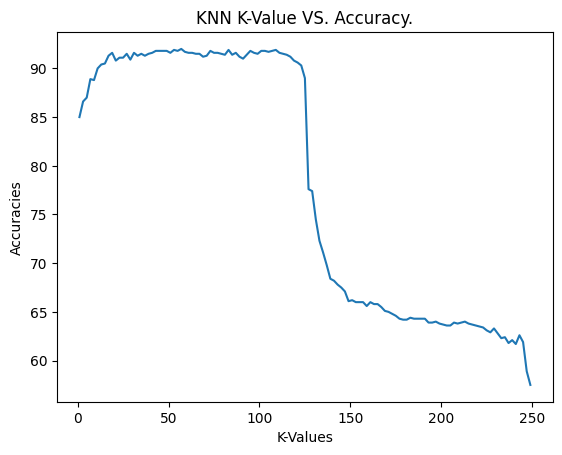

In [ ]:
plt.plot(k_vals, accuracies)
plt.title('KNN K-Value VS. Accuracy.')
plt.xlabel('K-Values')
plt.ylabel('Accuracies')